In [ ]:
!pip install optuna
!pip install catboost

In [ ]:
# Import libraries

import os
import optuna
import plotly 
import warnings
import plotly.offline

import numpy as np
import pandas as pd
import seaborn as sns
import cufflinks as cf
import lightgbm as gbm 
import missingno as msn
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
import plotly.figure_factory as ff

from scipy import stats
from matplotlib import style
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot

from tensorflow import keras
from tensorflow.keras.utils import plot_model

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
pd.options.mode.chained_assignment = None
init_notebook_mode(connected=True)
sns.set()
style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier, XGBRegressor  
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier

from sklearn import svm
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc, accuracy_score, f1_score, log_loss, recall_score, classification_report

In [ ]:
# Loading and Checking Dataset

data = pd.read_excel('heart.xlsx')
df = data.copy()
print('Rows     = ',data.shape[0]) 
print('Columns  = ',data.shape[1]) 
data.head()

Rows     =  917
Columns  =  7


,Age,Sex,CP,BP,HR,EA,HeartDisease
0,40,M,ATA,140,172,N,0
1,49,F,NAP,160,156,N,1
2,37,M,ATA,130,98,N,0
3,48,F,ASY,138,108,Y,1
4,54,M,NAP,150,122,N,0


In [ ]:
def missing (df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values

missing(df)

,Missing_Number,Missing_Percent
Age,0,0.0
Sex,0,0.0
CP,0,0.0
BP,0,0.0
HR,0,0.0
EA,0,0.0
HeartDisease,0,0.0


In [ ]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'BP', 'HR'], dtype='object')


Categorical Columns: Index(['Sex', 'CP', 'EA'], dtype='object')


In [ ]:
y = df['HeartDisease']
print(f'Percentage of patient had a HeartDisease:  {round(y.value_counts(normalize=True)[1]*100,2)} %  --> ({y.value_counts()[1]} patient)\nPercentage of patient did not have a HeartDisease: {round(y.value_counts(normalize=True)[0]*100,2)}  %  --> ({y.value_counts()[0]} patient)')

# There is a little imblanace but nothing in the disturbing level. We can use 'accuracy' metric as our evaluation metric.

Percentage of patient had a HeartDisease:  55.29 %  --> (507 patient)
Percentage of patient did not have a HeartDisease: 44.71  %  --> (410 patient)


In [ ]:
'''
CP	- chest pain 
BP	- blood pressure 
HR	- heart rate
EA  - ExerciseAngina
'''

data.nunique().to_frame().rename(columns={0: 'unique values'})

,unique values
Age,50
Sex,2
CP,4
BP,66
HR,119
EA,2
HeartDisease,2


In [ ]:
# Distribution of values in the dataset

data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,917.0,53.509269,9.437636,28.0,47.0,54.0,60.0,77.0
BP,917.0,132.540894,17.999749,80.0,120.0,130.0,140.0,200.0
HR,917.0,136.789531,25.467129,60.0,120.0,138.0,156.0,202.0
HeartDisease,917.0,0.552890,0.497466,0.0,0.0,1.0,1.0,1.0


In [ ]:
# EDA + FE: Exploratory Data Analysis + Feature Engineering

colors = ['lightcoral','deepskyblue',
          'orchid',    'tomato',
          'teal',      'darkcyan',
          'limegreen', 'darkorange']

def distribution_plot(column, title):

    fig = plt.figure(figsize=(12, 6))
    grid = GridSpec(nrows=2, ncols=1, figure=fig)
    color = np.random.choice(colors, 1)[0]

    ax0 = fig.add_subplot(grid[0, :])
    ax0.set_title(f'Histogram and BoxPlot of {title}', y=1.05)
    sns.histplot(column, ax=ax0, color=color)
    
    print(f'Skewness of {title} = {np.round(column.skew(), 3)}')

    ax1 = fig.add_subplot(grid[1, :])
    plt.axis('off')
    sns.boxplot(x=column, ax=ax1, color=color)

[]

<Figure size 1080x720 with 0 Axes>

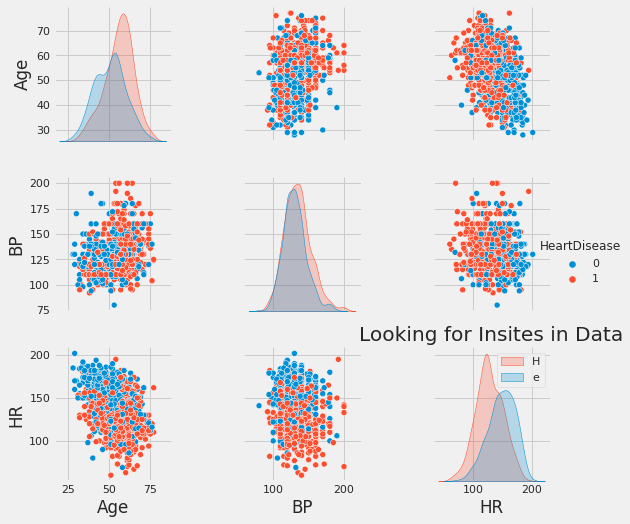

In [ ]:
plt.figure(figsize=(15,10))
sns.pairplot(df,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

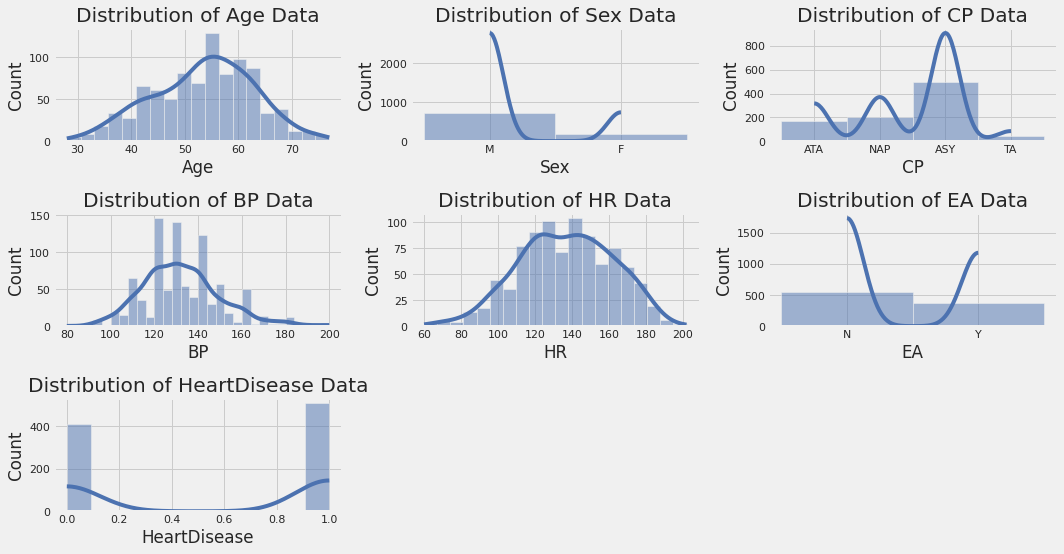

In [ ]:
plt.figure(figsize=(15,10))
for i,col in enumerate(df.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

Skewness of Age = -0.195


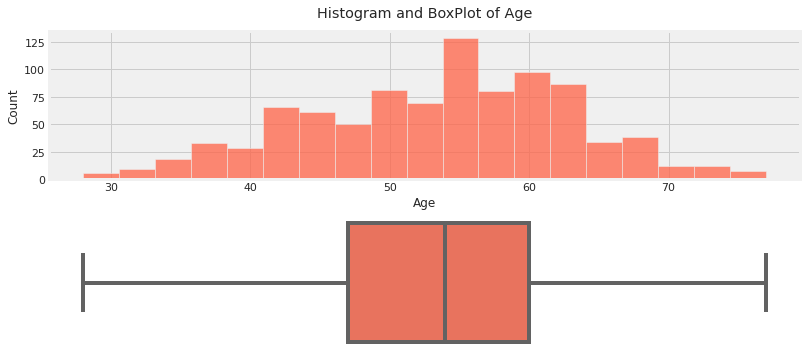

In [ ]:
# Age

distribution_plot(data.Age, 'Age')

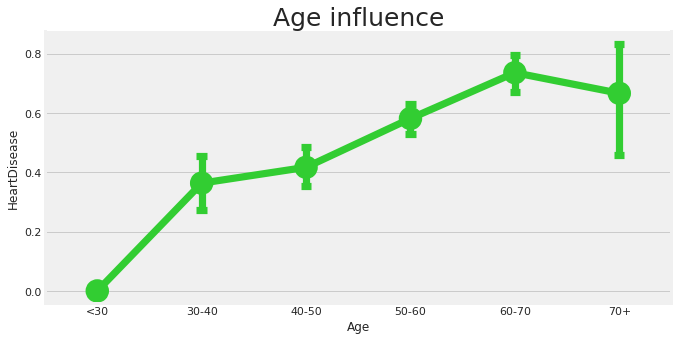

In [ ]:
def age_plot(data, col_name):
    age_data = data[[col_name, 'HeartDisease']]
    age_data[col_name] = pd.cut(age_data[col_name],
                               bins=[0, 30, 40, 50, 60, 70, 100],
                               labels=['<30',
                                       '30-40',
                                       '40-50',
                                       '50-60',
                                       '60-70',
                                       '70+'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(10, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=age_data, color=color) \
                 .set_title(f'{col_name} influence', fontsize=25)

age_plot(data, 'Age')

# Conclusion (linear relationship) : as the age of patients increases, the risk of heart disease increases (This disease affects mainly the elderly)

[Text(0, 0, '0'), Text(0, 0, '1')]

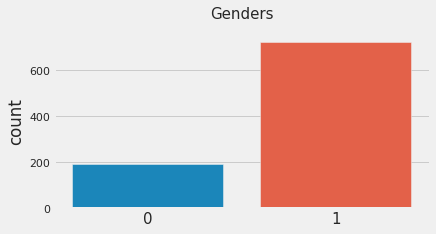

In [ ]:
# Gender

plt.figure(figsize=(6, 3))
gender_plot = sns.countplot(x=data.Sex)
gender_plot.set_title('Genders', fontsize=15, y=1.05)
gender_plot.set(xlabel=None)
gender_plot.set_xticklabels(gender_plot.get_xticklabels(), size=15)

# Men are almost 2.44 times more likely have a heart disease than women

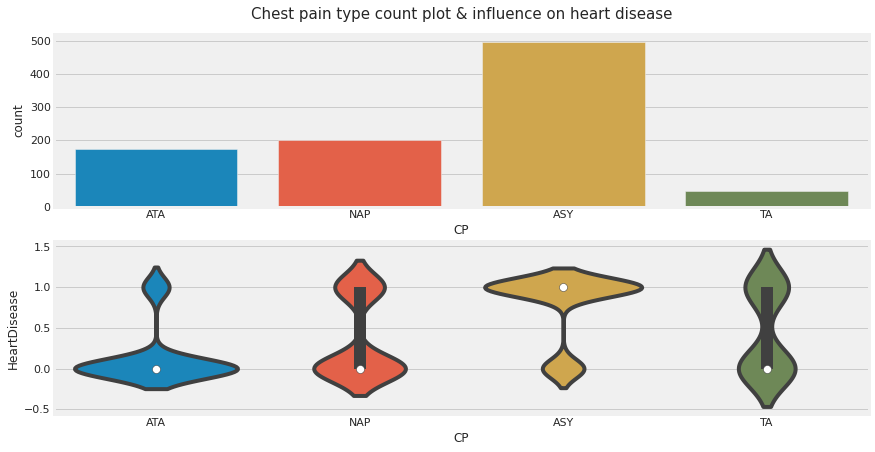

In [ ]:
'''
Chest pain type:
TA -> Typical Angina
ATA -> Atypical Angina
NAP -> Non-Anginal Pain
ASY -> Asymptomatic
No Pain -> 0
'''

fig = plt.figure(figsize=(13, 7))
grid = GridSpec(ncols=1, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :])
pain_type_plot = sns.countplot(x=data.CP, ax=ax1)
pain_type_plot.set_title('Chest pain type count plot &'
                         ' influence on heart disease',
                         fontsize=15, y=1.05)

ax2 = fig.add_subplot(grid[1, :])
sns.violinplot(x=data.CP, y='HeartDisease', data=data, ax=ax2)

# Conclusion : Asymptomacy in the most cases has a stronger influence on the disease’s progression, while patients with Atypical Angina have fewer (average) cases

Skewness of Blood pressure = 0.607


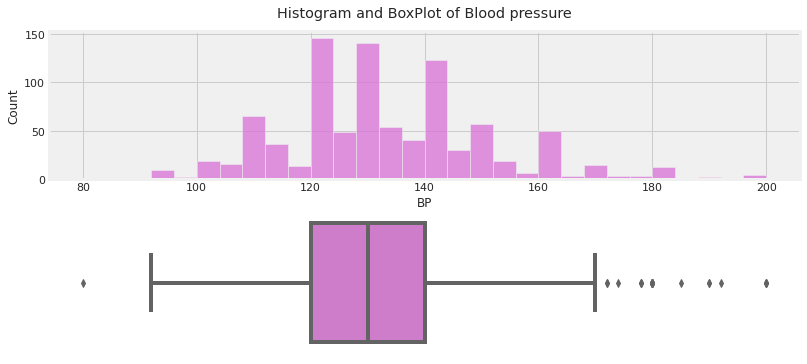

In [ ]:
# Blood pressure

distribution_plot(data.BP, 'Blood pressure')

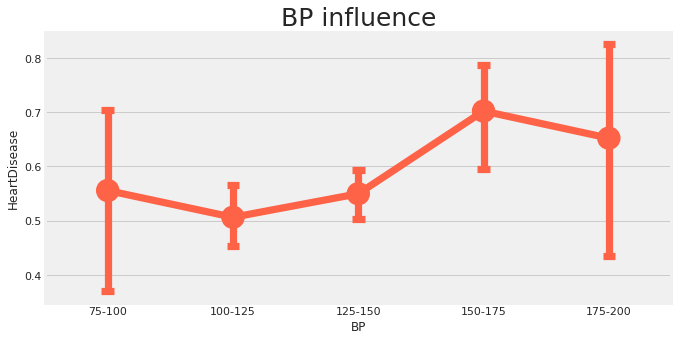

In [ ]:
def pressure_plot(data, col_name):

    pressure_data = data[[col_name, 'HeartDisease']]
    pressure_data[col_name] = pd.cut(pressure_data[col_name],
                               bins=[75, 100, 125, 150, 175, 200],
                               labels=['75-100',
                                       '100-125',
                                       '125-150',
                                       '150-175',
                                       '175-200'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(10, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=pressure_data, color=color) \
                 .set_title(f'{col_name} influence', fontsize=25)

pressure_plot(data, 'BP')

Skewness of Heart rate = -0.142


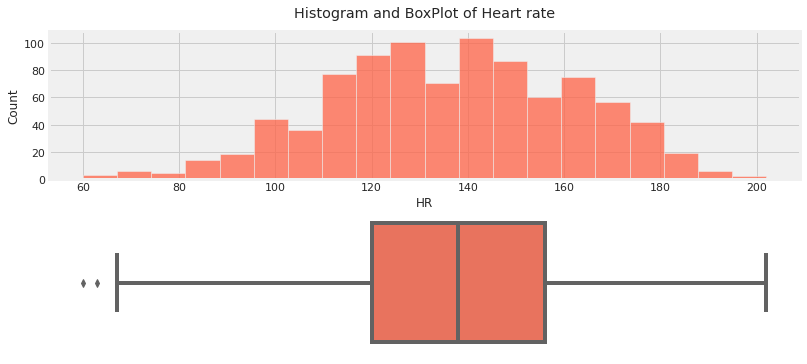

In [ ]:
# Heart rate

distribution_plot(data.HR, 'Heart rate')

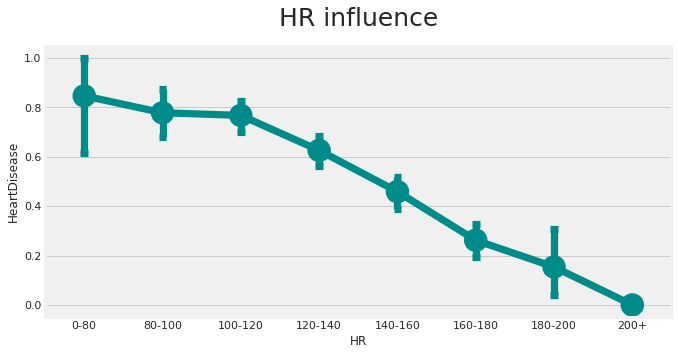

In [ ]:
def max_hr_plot(data, col_name):

    max_hr_data = data[[col_name, 'HeartDisease']]
    max_hr_data[col_name] = pd.cut(max_hr_data[col_name],
                               bins=[0, 80, 100, 120, 140, 160, 180, 200,
                                     1000],
                               labels=['0-80',
                                       '80-100',
                                       '100-120',
                                       '120-140',
                                       '140-160',
                                       '160-180',
                                       '180-200',
                                       '200+'])

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(10, 5))
    sns.pointplot(x=col_name, y='HeartDisease',
                  dodge=0.1, capsize=.1, data=max_hr_data, color=color) \
                 .set_title(f'{col_name} influence', fontsize=25, y=1.05)

max_hr_plot(data, 'HR')

# Explanation : It can therefore be concluded that the relationship is inverse in relation to the age of the patient To estimate your maximum age-related heart rate, subtract your age from 220

[Text(0, 0, 'No'), Text(0, 0, 'Yes')]

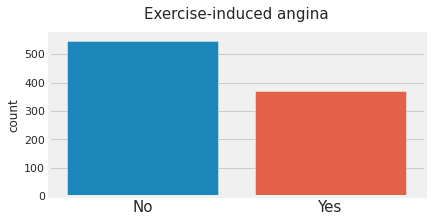

In [ ]:
# ExerciseAngina

plt.figure(figsize=(6, 3))
exercise_angina_plot = sns.countplot(x=data.EA)
exercise_angina_plot.set_title('Exercise-induced angina', fontsize=15, y=1.05)
exercise_angina_plot.set(xlabel=None)
exercise_angina_plot.set_xticklabels(['No', 'Yes'], size=15)

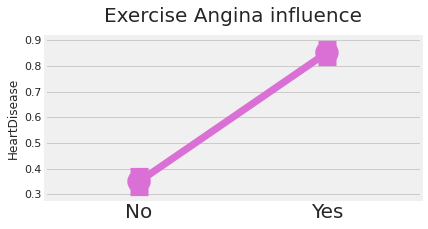

In [ ]:
def angina_plot(data, col_name):

    angina_data = data[[col_name, 'HeartDisease']]

    color = np.random.choice(colors, 1)[0]
    plt.figure(figsize=(6, 3))
    angina = sns.pointplot(x=col_name, y='HeartDisease',
                           dodge=0.1, capsize=.1,
                           data=angina_data,
                           color=color)
    angina.set_title('Exercise Angina influence',
                            fontsize=20, y=1.05)
    angina.set(xlabel=None)
    angina.set_xticklabels(['No', 'Yes'], size=20)

angina_plot(data, 'EA')

# ExerciseAngina: exercise-induced angina with 'Yes' almost 2.4 times more likley have a heart disaese than exercise-induced angina with 'No'.

In [ ]:
# Coding categorical data

cat_columns = [cname for cname in data.columns
                        if data[cname].dtype == 'object']

encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    data[col] = encoder.fit_transform(data[col])

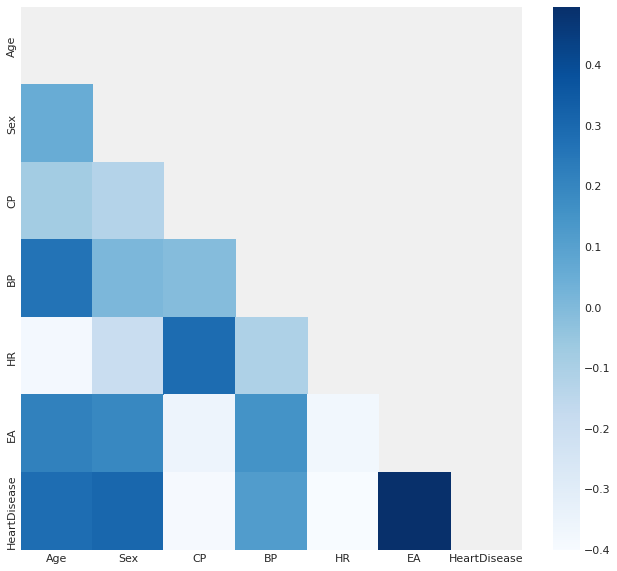

In [ ]:
# Heatmap

plt.figure(figsize=(10, 10))

corr_mask = np.triu(data.corr())
h_map = sns.heatmap(data.corr(), mask=corr_mask, cmap='Blues')
h_map

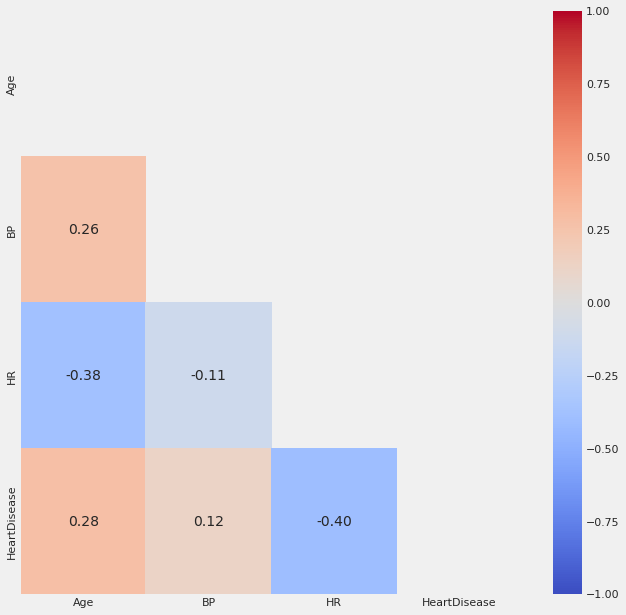

In [ ]:
numerical1= df.select_dtypes('number').columns

matrix = np.triu(df[numerical1].corr())
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap (df[numerical1].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

# Based on the matrix, we can observe weak level correlation between the numerical features and the target variable. Maximum heart rate has negative correlation with the heart disease.

In [ ]:
# Divide by X and y

X = data.drop(['HeartDisease'], axis=1)
y = data.HeartDisease

In [ ]:
# Machine Learning Models

rnd_state = 0
models_results = np.zeros(7)

def show_training_results(X, y, model_name, model, split_share=0.3, **kwargs):

    print(f'The model {model_name} with parameters : {kwargs}')
    m = model(**kwargs)

    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=split_share, random_state=rnd_state)

    m.fit(X_train, y_train)

    score = m.score(X_test, y_test)

    print(f'{model_name} score = {score:.{3}f}\n')

    plot_conf_mat(m, X_test, y_test)

    return score

def plot_conf_mat(model, X_test, y_test):

    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_pred, y_test)

    df_cm = pd.DataFrame(matrix, index = ['heart disease', 'Normal'],
                                columns = ['heart disease', 'Normal'])
    plt.figure(figsize = (7,3))
    sns.heatmap(df_cm,
                annot=True,
                cmap='Blues',
                fmt='.5g',
                annot_kws={"size": 25}).set_title('Confusion matrix', fontsize = 15, y=1.05)
    plt.xlabel('Predicted values', fontsize = 15)
    plt.ylabel('True values', fontsize = 15)
    plt.show()

The model LR with parameters : {'max_iter': 1000, 'class_weight': 'uniform'}
LR score = 0.812



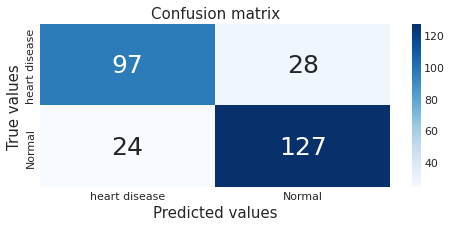

In [ ]:
# LogisticRegression

models_results[0] =   show_training_results(X, y,
                      'LR',
                      LogisticRegression,
                      max_iter=1000,
                      class_weight='uniform')

The model RF with parameters : {'n_estimators': 500, 'n_jobs': -1, 'random_state': 0}
RF score = 0.812



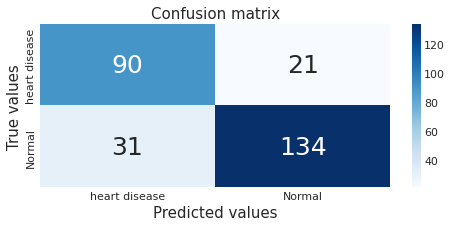

In [ ]:
# Random Forest

models_results[1] =   show_training_results(X, y,
                      'RF',
                      RandomForestClassifier,
                      n_estimators=500,
                      n_jobs=-1,
                      random_state=rnd_state)

The model kNN with parameters : {'n_neighbors': 1, 'algorithm': 'kd_tree', 'weights': 'uniform'}
kNN score = 0.620



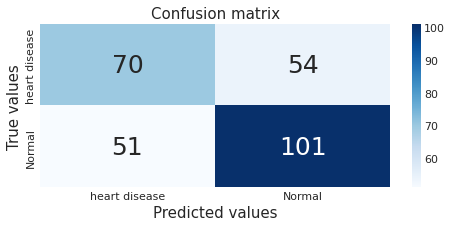

In [ ]:
# K-Nearest Neighbours

models_results[2] =   show_training_results(X, y,
                      'kNN',
                      KNeighborsClassifier,
                      n_neighbors=1,
                      algorithm='kd_tree',
                      weights='uniform')

The model GradBoost with parameters : {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 70, 'max_features': 2, 'n_estimators': 300}
GradBoost score = 0.786



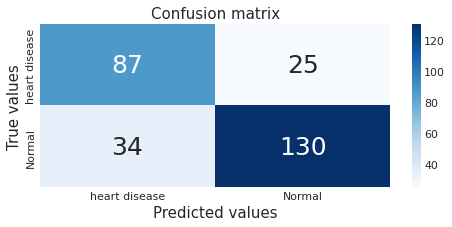

In [ ]:
# GradientBoostingClassifier

models_results[3] =   show_training_results(X, y,
                      'GradBoost',
                      GradientBoostingClassifier,
                      learning_rate=0.01,
                      loss='exponential',
                      max_depth=70,
                      max_features=2,
                      n_estimators=300)

The model XGBClassifier with parameters : {'learning_rate': 0.01, 'loss': 'exponential', 'max_depth': 70, 'max_features': 2, 'n_estimators': 300}
XGBClassifier score = 0.801



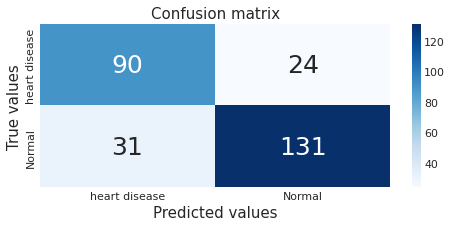

In [ ]:
# XGBClassifier --

models_results[4] =   show_training_results(X, y,
                      'XGBClassifier',
                      XGBClassifier,
                      learning_rate=0.01,
                      loss='exponential',
                      max_depth=70,
                      max_features=2,
                      n_estimators=300)

The model DecisionTreeClassifier with parameters : {'max_depth': 70, 'max_features': 2}
DecisionTreeClassifier score = 0.739



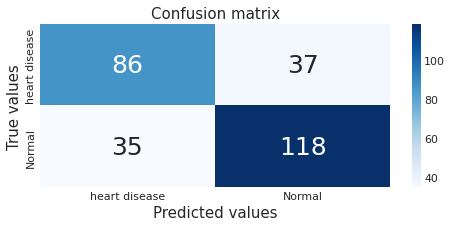

In [ ]:
# DecisionTreeClassifier --

models_results[5] =   show_training_results(X, y,
                      'DecisionTreeClassifier',
                      DecisionTreeClassifier,
                      max_depth=70,
                      max_features=2)

Neural Network score = 0.804


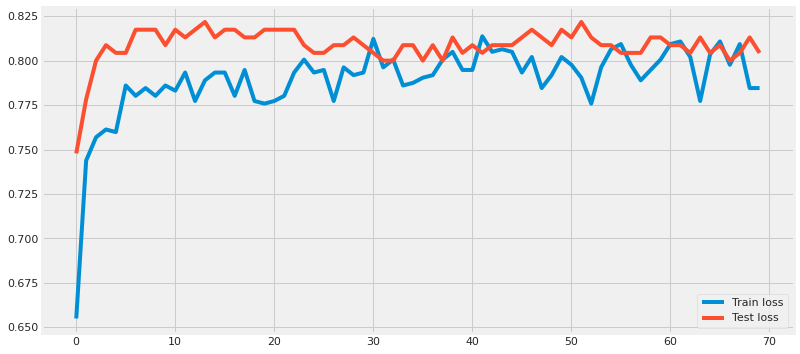

In [ ]:
# ANN (Artificial Neural Network)

os.environ["KMP_SETTINGS"] = "false"

def neural_net_results(X, y):

    y = keras.utils.to_categorical(y, 2)

    X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25,
                                                      random_state=rnd_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    model = keras.Sequential([
        keras.layers.Flatten(input_dim=X_train.shape[1]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
              batch_size=10, epochs=70,
              validation_data=(X_val, y_val),
              verbose=0)

    score = np.round(model.evaluate(X_val, y_val, verbose=0)[1], 3)
    print(f'Neural Network score = {score}')

    history_plot(history)

    return score

def history_plot(history):

    fig = plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label="Train loss")
    plt.plot(history.history['val_accuracy'], label="Test loss")
    plt.legend()

def plot_nn_model(model):
    plot_model(model, show_shapes=True)

models_results[-1] = neural_net_results(X, y)

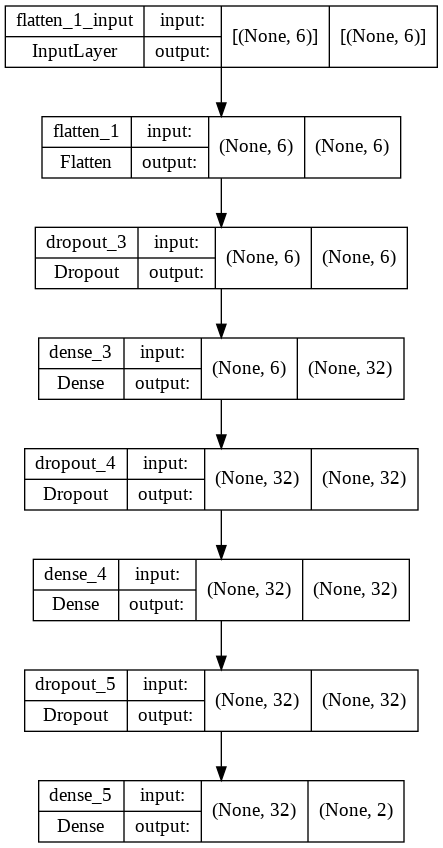

In [ ]:
# Neural Network structure

plot_model(keras.Sequential([
        keras.layers.Flatten(input_dim=X.shape[1]),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2, activation='softmax')
    ]), show_shapes=True)

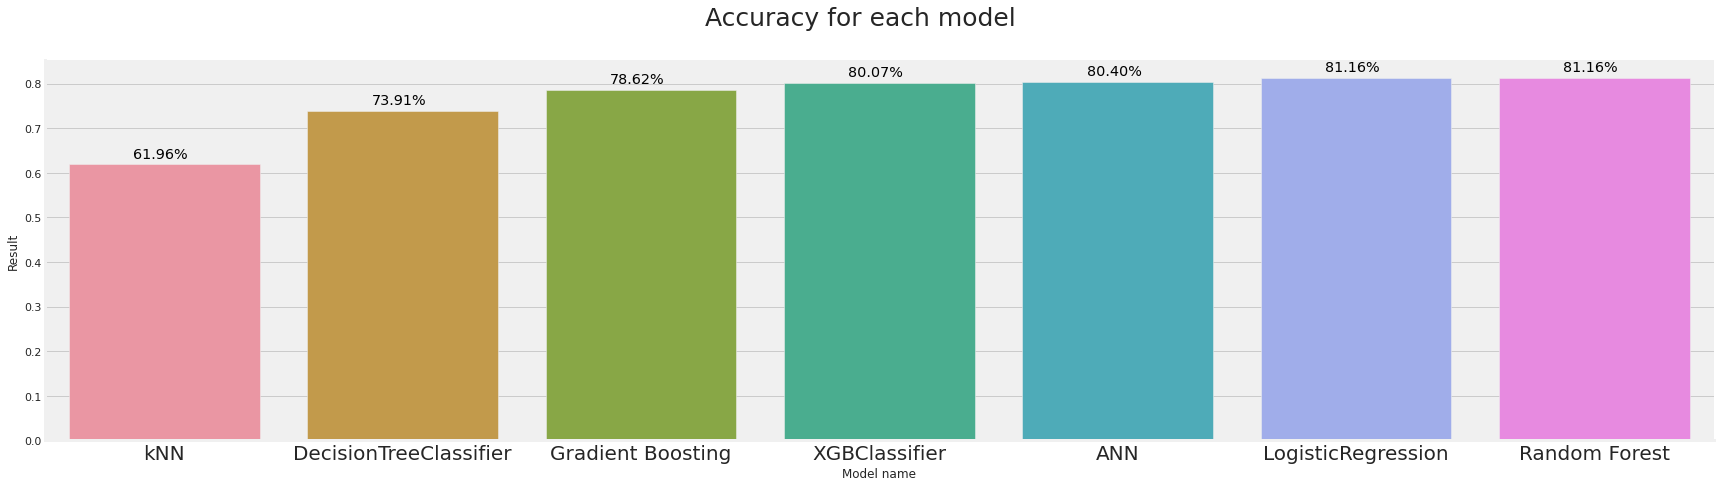

In [ ]:
# Models Evaluating

# Aggregation of results into one dataset

models_results = pd.DataFrame(models_results, columns=['Result'])
results1 = models_results.copy()
models_results['Model name'] = \
    ['LogisticRegression', 'Random Forest', 'kNN', 'Gradient Boosting', 'XGBClassifier', 'DecisionTreeClassifier', 'ANN']
models_results.sort_values(by=['Result'], inplace=True)

# Accuracy plot for each model type

g = sns.catplot(x='Model name', y='Result', data=models_results,
            height=6, aspect=4, kind='bar', legend=True)
g.fig.suptitle('Accuracy for each model', size=25, y=1.1)
ax = g.facet_axis(0,0)
ax.tick_params(axis='x', which='major', labelsize=20)
for p in ax.patches:
    ax.text(p.get_x() + 0.27,
            p.get_height() * 1.02,
           '{0:.2f}%'.format(p.get_height()*100),
            color='black',
            rotation='horizontal',
            size='x-large')

In [ ]:
# Different encoding and scaling of the data with different optimizations

In [ ]:
# Baseline Model

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

model = DummyClassifier(strategy='constant', constant=1)
pipe = make_pipeline(ct, model)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['DummyClassifier']
dummy_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
dummy_result_df

model : DummyClassifier(constant=1, strategy='constant') and  accuracy score is : 0.6123


,Accuracy
DummyClassifier,0.6123


In [ ]:
#data - l
#df - o

In [ ]:
# Logistic & Linear Discriminant & SVC & KNN

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors']
result_df1 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df1

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.7899
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8116
model : SVC() and  accuracy score is : 0.7065
model : KNeighborsClassifier() and  accuracy score is : 0.6486


,Accuracy
Logistic,0.7899
LinearDiscriminant,0.8116
SVM,0.7065
KNeighbors,0.6486


In [ ]:
# Logistic & Linear Discriminant & SVC & KNN with Scaler

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
s= StandardScaler()
ct1= make_column_transformer((ohe,categorical),(s,numerical))  

lr = LogisticRegression(solver='liblinear')
lda= LinearDiscriminantAnalysis()
svm = SVC(gamma='scale')
knn = KNeighborsClassifier()

models = [lr,lda,svm,knn]

for model in models: 
    pipe = make_pipeline(ct1, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Logistic_scl','LinearDiscriminant_scl','SVM_scl','KNeighbors_scl']
result_df2 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df2

# As expected, with scaler, both KNN and SVM did a better job with the scaler than their previous performances.

model : LogisticRegression(solver='liblinear') and  accuracy score is : 0.7899
model : LinearDiscriminantAnalysis() and  accuracy score is : 0.8116
model : SVC() and  accuracy score is : 0.8116
model : KNeighborsClassifier() and  accuracy score is : 0.8043


,Accuracy
Logistic_scl,0.7899
LinearDiscriminant_scl,0.8116
SVM_scl,0.8116
KNeighbors_scl,0.8043


In [ ]:
# Ensemble Models (AdaBoost & Gradient Boosting & Random Forest & Extra Trees)

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

ada = AdaBoostClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
et=  ExtraTreesClassifier(random_state=0)

models = [ada,gb,rf,et]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))
    print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

model_names = ['Ada','Gradient','Random','ExtraTree']
result_df3 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df3

# Accuracy scores are very close to each other. Both Random Forest and Extra tree got similar accuracy scores. Both model can be improved by hyperparameter tuning.

model : AdaBoostClassifier(random_state=0) and  accuracy score is : 0.7572
model : GradientBoostingClassifier(random_state=0) and  accuracy score is : 0.779
model : RandomForestClassifier(random_state=0) and  accuracy score is : 0.8007
model : ExtraTreesClassifier(random_state=0) and  accuracy score is : 0.7971


,Accuracy
Ada,0.7572
Gradient,0.7790
Random,0.8007
ExtraTree,0.7971


In [ ]:
# XGBoost & LightGBM & Catboost

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ohe= OneHotEncoder()
ct= make_column_transformer((ohe,categorical),remainder='passthrough')  

xgbc = XGBClassifier(random_state=0)
lgbmc=LGBMClassifier(random_state=0)

models = [xgbc,lgbmc]

for model in models: 
    pipe = make_pipeline(ct, model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['XGBoost','LightGBM']
result_df4 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df4

# With their deafult values, Catboost(its capability to handle categorical variables without doing any preprocessing) did better job than the other two models.

,Accuracy
XGBoost,0.7899
LightGBM,0.7754


In [ ]:
# CATBOOST

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))

model_names = ['Catboost_default']
result_df5 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



,Accuracy
Catboost_default,0.808


In [ ]:
# Catboost HyperParameter Tuning with Optuna

def objective(trial):
    X= df.drop('HeartDisease', axis=1)
    y= df['HeartDisease']
    categorical_features_indices = np.where(X.dtypes != np.float)[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cat_cls = CatBoostClassifier(**param)

    cat_cls.fit(X_train, y_train, eval_set=[(X_test, y_test)], cat_features=categorical_features_indices,verbose=0, early_stopping_rounds=100)

    preds = cat_cls.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-02-25 06:35:35,695] A new study created in memory with name: no-name-777ab86b-b4cd-4bec-819f-4c5f3c62d62f
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

[I 2022-02-25 06:35:38,652] Trial 0 finished with value: 0.8079710144927537 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.03932701637403889, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8079710144927537.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use 

Number of finished trials: 50
Best trial:
  Value: 0.8297101449275363
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.010379475289685795
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 7.231149398384369


In [ ]:
'''
Parameters:

Objective: Supported metrics for overfitting detection and best model selection

colsample_bylevel: this parameter speeds up the training and usually does not affect the quality.

depht : Depth of the tree.

boosting_type : By default, the boosting type is set to for small datasets. This prevents overfitting but it is expensive in terms of computation. Try to set the value of this parameter to to speed up the training.

bootstrap_type : By default, the method for sampling the weights of objects is set to . The training is performed faster if the method is set and the value for the sample rate for bagging is smaller than 1.


Number of finished trials: 50
Best trial:
  Value: 0.8297101449275363
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.010379475289685795
    depth: 5
    boosting_type: Plain
    bootstrap_type: Bayesian
    bagging_temperature: 7.231149398384369
'''

In [ ]:
# Best model with new parameters

accuracy =[]
model_names =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = CatBoostClassifier(verbose=False,random_state=0,
                          objective= 'CrossEntropy',
    colsample_bylevel= 0.010379475289685795,#0.04292240490294766,#
    depth= 10,#5,#
    boosting_type= 'Plain',
    bootstrap_type= 'Bayesian',#'MVS',#
    bagging_temperature= 7.231149398384369)

model.fit(X_train, y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test))
y_pred = model.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
result_df6

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       107
           1       0.86      0.86      0.86       169

    accuracy                           0.83       276
   macro avg       0.82      0.82      0.82       276
weighted avg       0.83      0.83      0.83       276



,Accuracy
Catboost_tuned,0.8297


In [ ]:
# Feature Importance

feature_importance = np.array(model.get_feature_importance())
features = np.array(X_train.columns)
fi={'features':features,'feature_importance':feature_importance}
df_fi = pd.DataFrame(fi)
df_fi.sort_values(by=['feature_importance'], ascending=True,inplace=True)
df_fi

,features,feature_importance
3,BP,0.254275
4,HR,2.085365
0,Age,5.447632
1,Sex,14.287232
2,CP,31.121909
5,EA,46.803587


,Accuracy
DummyClassifier,0.6123
KNeighbors,0.6486
SVM,0.7065
Ada,0.7572
LightGBM,0.7754
Gradient,0.7790
Logistic,0.7899
Logistic_scl,0.7899
XGBoost,0.7899
ExtraTree,0.7971


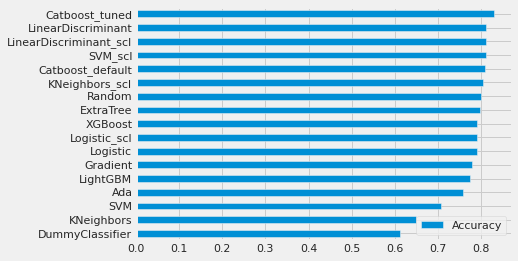

In [ ]:
# Model Comparison

result_final = pd.concat([dummy_result_df,result_df1,result_df2,result_df3,result_df4,result_df5,result_df6],axis=0)
result_final.sort_values(by=['Accuracy'], ascending=True,inplace=True)
result_final.plot.barh()
result_final
#fig = px.bar(result_final, x='Accuracy', y=result_final.index,title='Model Comparison',height=600,labels={'index':'MODELS'})
#fig.show()

In [ ]:
'''
developed model to classifiy heart disease cases.
made the detailed exploratory analysis.
decided which metric to use.
analyzed both target and features in detail.
transformed categorical variables into numeric so we can use them in the model.
used pipeline to avoid data leakage.
looked at the results of the each model and selected the best one for the problem on hand.
made hyperparameter tuning of the Catboost with Optuna to see the improvement
looked at the feature importance.
'''

In [ ]:
###